CNN RNN等等无法解决输入输出序列长度不等的问题，编码器-解码器可以解决此问题。
编码器-解码器作为高层次的设计架构，其并不与任何的具体的神经网络架构绑定。

编码器-解码器架构是一个通用的设计架构，用于解决序列到序列（sequence-to-sequence）问题，其中输入序列和输出序列的长度可能不同。
序列长度的得出，可以简单理解为利用最大似然估计，最大化输出序列基于输入序列的条件概率。

在编码器-解码器架构中，编码器是一个神经网络，它将输入序列转换为一个固定维度的向量，这个向量被称为编码器输出。然后，这个编码器输出被传递给解码器，解码器根据编码器输出和目标序列生成预测序列。以机器翻译为例：编码器依次处理源序列的每个词，最终得到语义向量c（上下文变量），解码器以句子开头为输入，根据c和句子开头生成第一个词，然后根据c和第一个词生成第二个词，以此类推，直到生成句子结尾。


In [ ]:
#以RNN作为基础构建Encoder Decoder
#这一单元格只是一个简单示例，之后会重新定义Encoder Decoder
import torch
import torch.nn as nn

#编码器
class Encoder(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers):
        super(Encoder,self).__init__()
        self.rnn=nn.RNN(input_size,hidden_size,num_layers)

    def forward(self,x,hidden):
        x,hidden=self.rnn(x,hidden) #这里的hidden相当于之前的state
        return hidden 

#解码器
class Decoder(nn.Module):
    def __init__(self,output_size,hidden_size,num_layers):
        super(Decoder,self).__init__()
        self.rnn=nn.RNN(output_size,hidden_size,num_layers)
        self.linear=nn.Linear(hidden_size,output_size)
    
    def forward(self,x,hidden):
        x,state=self.rnn(x,hidden)
        x=self.linear(x)
        return x,state

#seq2seq
class seq2seq(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder

    def forward(self,encoder_inputs,decoder_inputs):
        return self.decoder(decoder_inputs,self.encoder(encoder_inputs))
        #encoder_inputs是编码器的输入，decoder_inputs是解码器的输入

In [40]:
#假设数据集 soundmark是26个英文字母的读音，alphabet是26个英文字母
#目标是根据读音序列生成字母序列
soundmark = [
    'eɪ', 'biː', '/siː/', '/diː/', '/iː/', '/ɛf/', '/dʒiː/', '/eɪtʃ/', '/aɪ/', '/dʒeɪ/',
    '/keɪ/', '/ɛl/', '/ɛm/', '/ɛn/', '/oʊ/', '/piː/', '/kjuː/', '/ɑːr/', '/ɛs/', '/tiː/',
    '/juː/', '/viː/', '/ˈdʌbəl.juː/', '/ɛks/', '/waɪ/', '/zɛd/'
]

alphabet=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']


In [41]:
import random

t=10000 #数据总条数
r=0.9 #扰动项，生成正确序列的概率，可以让数据集包含一些错误数据

seq_len=6
src_tokens,tgt_tokens=[],[] #源序列，目标序列

for i in range(t):
    src,tgt=[],[]
    for j in range(seq_len):
        ind = random.randint(0,25) #随机生成整数
        src.append(soundmark[ind])
        if random.random()<r:
            tgt.append(alphabet[ind])
        else:
            tgt.append(alphabet[random.randint(0,25)])
    src_tokens.append(src)
    tgt_tokens.append(tgt)


In [42]:
from collections import Counter

#构建匿名函数，for sublist in l :遍历外层列表l中的每一个子列表，for item in sublist：遍历每个子列表的每个元素
flatten = lambda l: [item for sublist in l for item in sublist] #展平数组

#构建词表
class Vocab:
    def __init__(self,tokens):
        self.tokens=tokens #二维列表
        self.token2index={'<bos>':0,'<eos>':1 } #两个特殊词元，分别代表开始和结束
        #将词元按照频率排序后生成列表
        self.token2index.update({
            token:index+2
            for index, (token,count) in enumerate(sorted(Counter(flatten(tokens)).items(),key=lambda x:x[1],reverse=True))
        })
        
        self.index2token={index:token for token,index in self.token2index.items()}
        
    def __getitem__(self,query): #如果query是字符串或者整数，则返回query在字典中的索引，否则返回' '<
        if isinstance(query,(str,int)): #如果query是字符串或者整数
            if isinstance(query,str):
                return self.token2index.get(query,0)  #如果query是字符串，则返回query在字典中的索引，否则返回0
            elif isinstance(query,int):
                return self.index2token.get(query,'<unk>') #如果query是整数，则返回query在字典中的索引，否则返回' '<
        elif  isinstance(query,(list,tuple)):
            return [self.__getitem__(item) for item in query]
    
    def __len__(self): #返回字典的长度
        return len(self.index2token)   

In [43]:
from torch.utils.data import DataLoader,TensorDataset

src_vocab,tgt_vocab=Vocab(src_tokens),Vocab(tgt_tokens) #构建词表
print(src_vocab,tgt_vocab)
#增加结尾标识
src_data=torch.tensor([src_vocab[line+['<eos>']] for line in src_tokens])
tgt_data=torch.tensor([tgt_vocab[line+['<eos>']] for line in tgt_tokens])

train_size=int(0.8*len(src_data))
test_size=int(0.2*len(src_data))
batch_size=16

train_loader=DataLoader(TensorDataset(src_data[:train_size],tgt_data[:train_size]),batch_size=batch_size)
test_loader=DataLoader(TensorDataset(src_data[train_size:],tgt_data[train_size:]),batch_size=1)


<__main__.Vocab object at 0x000001A7A4BE72F0> <__main__.Vocab object at 0x000001A7A4BE5730>


In [44]:
class Encoder_(nn.Module):
    def __init__(self,vocab_size,ebd_size,hidden_size,num_layers):
        super().__init__()
        self.embedding=nn.Embedding(vocab_size,ebd_size) #将token转为向量 
        self.rnn=nn.RNN(ebd_size,hidden_size,num_layers=num_layers)
        
    def forward(self,encoder_inputs):
        #inputs: [batch_size,seq_len]-->[batch_size,seq_len,ebd_size]-->[seq_len,batch_size,ebd_size]
        encoder_inputs=self.embedding(encoder_inputs).permute(1,0,2)
        output,hidden=self.rnn(encoder_inputs)
        
        return hidden
    
#hidden的形状是[batch_size,num_layers,hidden_size]
#最后时刻的最后一个隐层输出的隐状态就是上下文变量c

class Decoder_(nn.Module):
    def __init__(self,vocab_size,ebd_size,hidden_size,num_layers):
        super().__init__()
        self.embedding=nn.Embedding(vocab_size,ebd_size)
        self.rnn=nn.RNN(ebd_size+hidden_size,hidden_size,num_layers=num_layers)
        self.linear=nn.Linear(hidden_size,vocab_size)
        
    def forward(self,decoder_inputs,encoder_states):
        '''decoder_inputs: [batch_size,seq_len]-->[batch_size,seq_len,ebd_size]-->[seq_len,batch_size,ebd_size]'''
        decoder_inputs=self.embedding(decoder_inputs).permute(1,0,2)
        context=encoder_states[-1]
        context=context.repeat(decoder_inputs.size(0),1,1) #重复context的维度
        output,hidden=self.rnn(torch.cat((decoder_inputs,context),-1),encoder_states)
        #cat拼接iple张量，-1表示最后一个维度，即[batch_size,seq_len,ebd_size+hidden_size]
        logits=self.linear(output) #logits: [seq_len,batch_size,vocab_size]
        return logits,hidden 
        
class seq2seq_(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
        
    def forward(self,encoder_inputs,decoder_inputs):
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states) #返回decoder的输出和隐层状态

100%|██████████| 20/20 [01:01<00:00,  3.09s/it]


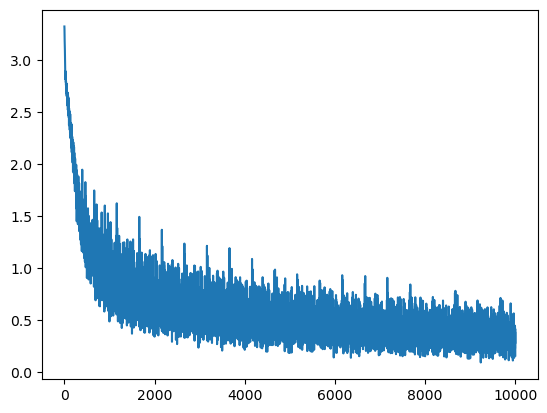

In [47]:
from tqdm import *
import matplotlib.pyplot as plt

lr=0.001
num_epochs=20
hidden_size=128

encoder=Encoder_(len(src_vocab),len(src_vocab),hidden_size,num_layers=2)
decoder=Decoder_(len(tgt_vocab),len(tgt_vocab),hidden_size,num_layers=2)
model=seq2seq_(encoder,decoder)

criterion=nn.CrossEntropyLoss(reduction='none')
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

loss_history=[]
model.train()
for epoch in tqdm(range(num_epochs)):
    for encoder_inputs,decoder_targets in train_loader:
        encoder_inputs,decoder_targets = encoder_inputs,decoder_targets
        #偏移一位作为decoder的输入
        #decoder的输入的第一位是bos，最后一位是eos
        bos_column=torch.tensor([tgt_vocab['<bos>']] * decoder_targets.shape[0]).reshape(-1,1)
        decoder_inputs=torch.cat((bos_column,decoder_targets[:,:-1]),1) 
        pred,_=model(encoder_inputs,decoder_inputs) 
        loss=criterion(pred.permute(1,2,0),decoder_targets).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

plt.plot(loss_history,label='loss')
plt.show()